# Feature-view on Data Cubes
## Example: Irrigated agriculture in Egypt with Sentinel-2

## Description

Identifying agricultural fields in Egypt with a irrigation system, which is called ["center pivot irrigation"](https://en.m.wikipedia.org/wiki/Center_pivot_irrigation). A rotating sprinkler system generates the typical round areas: ![](https://upload.wikimedia.org/wikipedia/commons/1/17/PivotIrrigationOnCotton.jpg)

Satellite images can be used to document the extent and amount of the fields [as illustrated by this example using images from the Proba-V satellite](https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/proba-v/image-of-the-week/-/article/pivot-irrigation-fields-egypt)

![](https://earth.esa.int/documents/10174/2555664/Proba-V-2014-2016-Pivot-Irrigation-Fields-Egypt-full.jpg)

Images from this area makes it a good testbed for Object-Based Image Analysis (OBIA) in data cubes:
- The resultion of Sentinel-2 is high enough to capture the fields and its details
- Images from this area are not frequently obscurred by clouds
- As shown in the example, the area is quite dynamic and allows to investigate temporal patterns.

This is a simple example, whichs serves as a first test.

## Pre-analysis steps
Make sure the file s2-workflow.sh was executed successfully, then import the datacube.

In [8]:
%matplotlib inline
import datacube

## Load data
Load data from study area

In [27]:
dc = datacube.Datacube()
dc.list_products()

,name,description,instrument,platform,product_type,lon,lat,format,time,label,creation_time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
1,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,None,None,JPEG2000,None,None,None,NaN,NaN,NaN,NaN
3,s2a_sen2cor_granule,Sentinel-2 Level 2 - Sen2Cor Bottom of Atmosph...,MSI,SENTINEL_2A,S2MSI2Ap,None,None,JPEG2000,None,None,None,NaN,NaN,NaN,NaN
4,s2a_sen2cor_granule_ingested_10,Sentinel-2A MSI L2A 10 metre,MSI,SENTINEL_2A,S2MSI2Ap,None,None,NetCDF,None,None,None,EPSG:32635,"(-10, 10)","(100000.0, 100000.0)","(y, x)"
2,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,None,None,JPEG2000,None,None,None,NaN,NaN,NaN,NaN


In [26]:
study_area = dc.load(product='s2a_sen2cor_granule_ingested_10', x=(661741, 693067), y=(2449603,2465032), crs='EPSG:32635')
print(study_area)

<xarray.Dataset>
Dimensions:  (time: 1, x: 3133, y: 1544)
Coordinates:
  * time     (time) datetime64[ns] 2018-10-09T08:50:22.975000
  * y        (y) float64 2.465e+06 2.465e+06 2.465e+06 ... 2.45e+06 2.45e+06
  * x        (x) float64 6.617e+05 6.618e+05 6.618e+05 ... 6.931e+05 6.931e+05
Data variables:
    blue     (time, y, x) int16 1937 1883 1910 1920 1949 ... 2124 2131 2082 2102
    green    (time, y, x) int16 3212 3218 3305 3286 3276 ... 3431 3438 3436 3411
    red      (time, y, x) int16 4844 4790 4914 4904 4973 ... 5098 5103 5083 5024
    nir      (time, y, x) int16 5546 5450 5628 5588 5639 ... 5863 5837 5813 5777
Attributes:
    crs:      EPSG:32635


Calculate the NDVI 

In [4]:
nir = study_area.nir
red = study_area.red
ndvi = ((nir - red) / (nir + red))

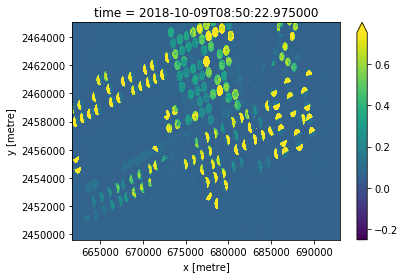

In [13]:
ndvi.plot(vmin=-0.25, vmax=0.75)

## Question:
How many irrigated agricultural fields are within this area and how many of them are fully used and how many are only partially used?